## Data Reading

In [2]:
# !kaggle competitions download -c csai-253-project-phase-2

In [3]:
import os
import pandas as pd

current_path = os.getcwd()
data_path = os.path.join(current_path, "data", "raw", "train.csv")

df = pd.read_csv(data_path)
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 842396 entries, 0 to 938582
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   flow_time         842396 non-null  float64
 1   header_size       842396 non-null  float64
 2   packet_duration   842396 non-null  float64
 3   overall_rate      842396 non-null  float64
 4   src_rate          842396 non-null  float64
 5   dst_rate          842396 non-null  float64
 6   fin_packets       842396 non-null  float64
 7   urg_packets       842396 non-null  float64
 8   rst_packets       842396 non-null  float64
 9   max_value         842396 non-null  float64
 10  value_covariance  842396 non-null  float64
 11  fin_flags         842396 non-null  int64  
 12  syn_flags         842396 non-null  int64  
 13  rst_flags         842396 non-null  int64  
 14  psh_flags         842396 non-null  int64  
 15  ack_flags         842396 non-null  int64  
 16  protocol_http     842396 

In [4]:
target = df['label']
labels = target.unique()
selected_features = ["flow_time", "header_size", "packet_duration", "overall_rate", "src_rate", "fin_packets", "urg_packets", "rst_packets", "max_value", "value_covariance", "fin_flags", "syn_flags", "rst_flags", "psh_flags", "ack_flags", "protocol_http", "protocol_https", "protocol_tcp", "protocol_udp", "protocol_icmp"]
x = df[selected_features]
print(target.unique())

['DDoS' 'DoS' 'BenignTraffic' 'Mirai' 'Recon' 'MITM']


In [5]:
target.value_counts() #/ df.shape[0] *100

label
DDoS             597897
DoS              158496
Mirai             51273
BenignTraffic     21985
Recon              6432
MITM               6313
Name: count, dtype: int64

## Dimensionality reduction

In [18]:
from cuml import TSNE

tsne = TSNE(perplexity=45, n_iter=2500, metric='cosine', random_state=42)
reduced_data = tsne.fit_transform(x)
# reduced_data

/home/maro/miniconda3/envs/rapids-24.04/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [23:00:31.788318] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [19]:
reduced_data.max() - reduced_data.min()

0    42071.597656
1    84907.820312
dtype: float32

In [5]:
from cuml import PCA

pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(x)

## Visualizing Target

Total visualized data points 756393


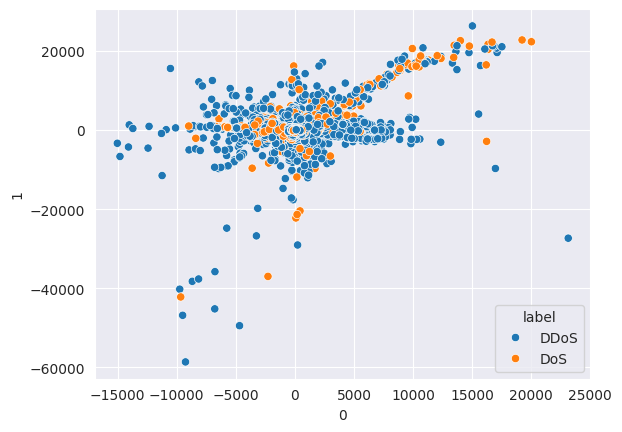

Total visualized data points 619882


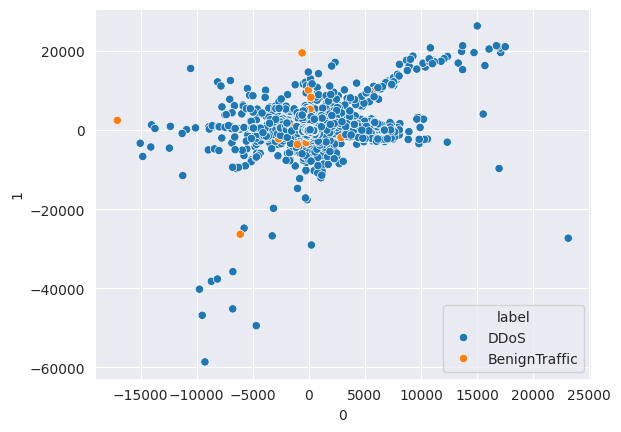

Total visualized data points 649170


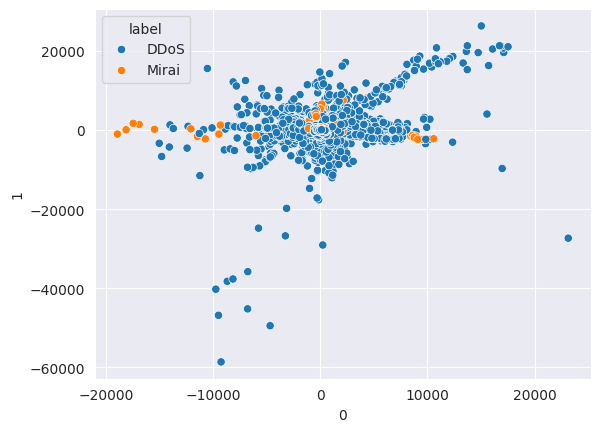

Total visualized data points 604329


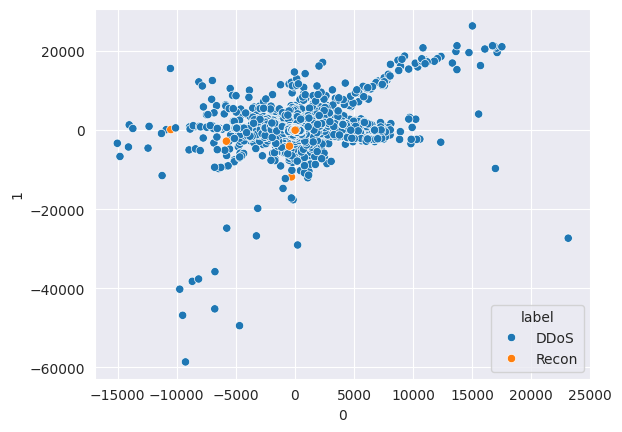

Total visualized data points 604210


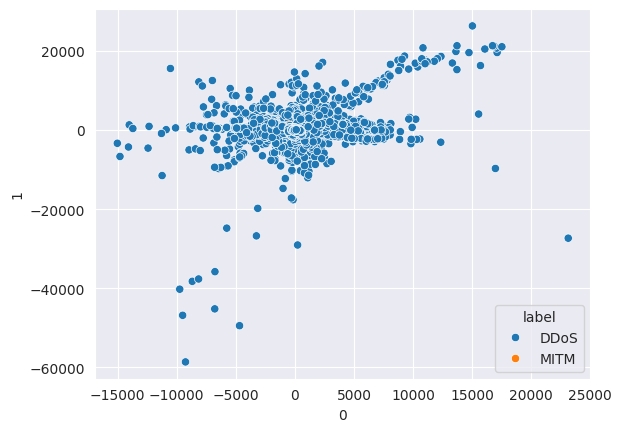

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

#One Vs One labels distribution
def visualize_DDoS(other_col: str, first_col: str = 'DDoS'):
    if other_col == first_col: return
    new_label = target.mask((target != other_col) & (target != first_col), '0')
    indices_to_visualize = new_label[new_label!='0']
    print('Total visualized data points', len(indices_to_visualize))
    sns.scatterplot(x=reduced_data.loc[indices_to_visualize.index][0], y=reduced_data.loc[indices_to_visualize.index][1], hue = indices_to_visualize)
    plt.show()

for label in labels:
    visualize_DDoS(label)

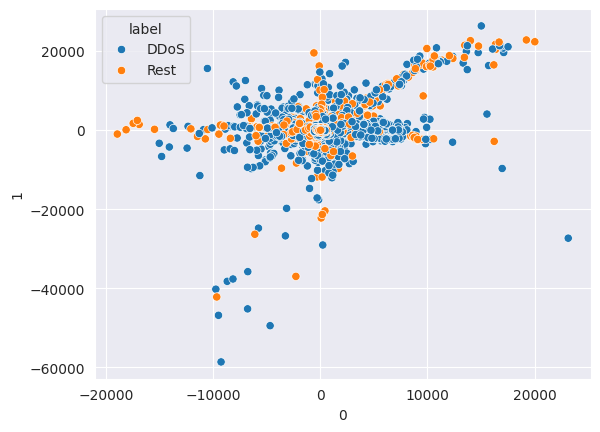

In [21]:
# DDoS Vs Rest labels
def ovr_visualize_DDoS():
    new_label = target.mask((target != 'DDoS'), 'Rest')
    sns.scatterplot(x=reduced_data.loc[new_label.index][0], y=reduced_data.loc[new_label.index][1], hue = new_label)
    plt.show()

ovr_visualize_DDoS()

## Undersample

In [ ]:
def get_strategy(y):
    return dict(DDoS = 200000)

In [28]:
from imblearn.under_sampling import EditedNearestNeighbours

sampler = EditedNearestNeighbours(sampling_strategy=['DDoS'], kind_sel='all', n_jobs=-1, n_neighbors=150)
X, y = sampler.fit_resample(x, target)

KeyboardInterrupt: 

In [34]:
reduced_data = tsne.fit_transform(X)
reduced_data

[W] [00:20:46.970005] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


,0,1
0,-73.746460,-15.804090
1,-9.658375,-73.239197
2,-138.092438,205.381226
3,182.342896,30.305021
4,7.471888,-22.613823
...,...,...
700076,-143.421356,941.439941
700077,-73.717644,932.801636
700078,-26.702646,-12.511733
700079,-35.725647,132.648087


In [42]:
y.value_counts()

label
DDoS             455582
DoS              158496
Mirai             51273
BenignTraffic     21985
Recon              6432
MITM               6313
Name: count, dtype: int64

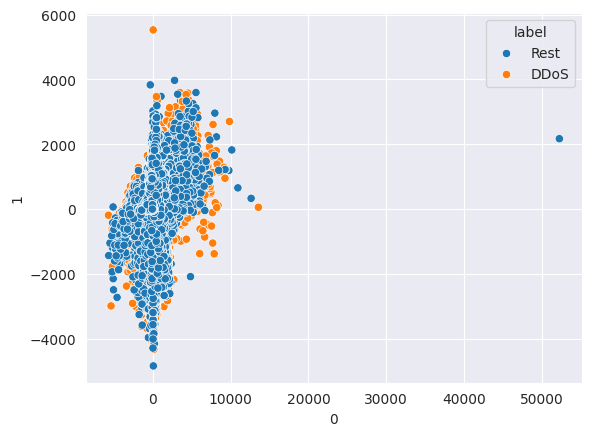

In [40]:
# DDoS Vs Rest labels
def ovr_visualize_DDoS():
    new_label = y.mask((y != 'DDoS'), 'Rest')
    sns.scatterplot(x=reduced_data.loc[new_label.index][0], y=reduced_data.loc[new_label.index][1], hue = new_label)
    plt.show()

ovr_visualize_DDoS()

Total visualized data points 614078


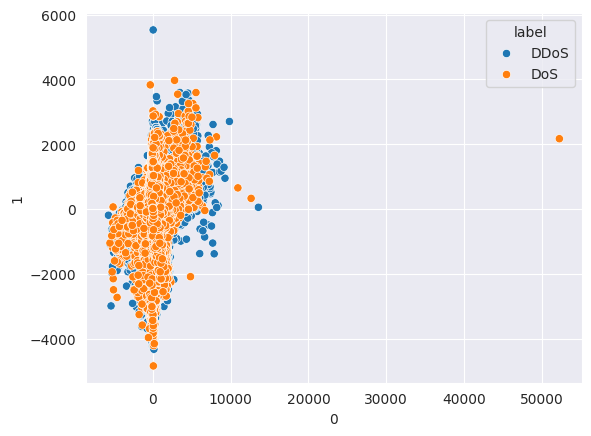

Total visualized data points 477567


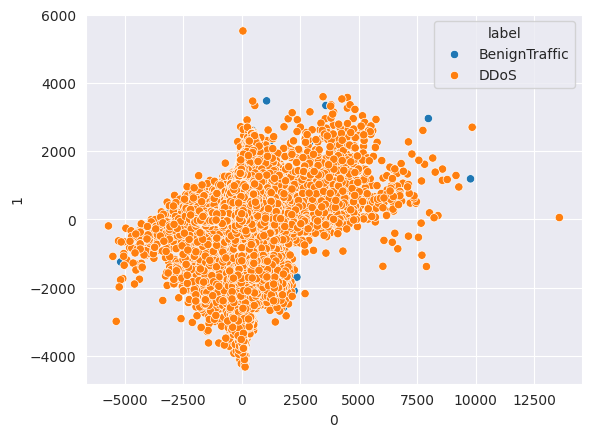

Total visualized data points 506855


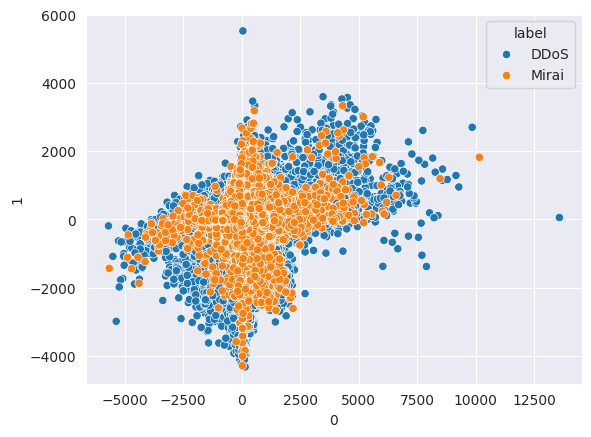

Total visualized data points 462014


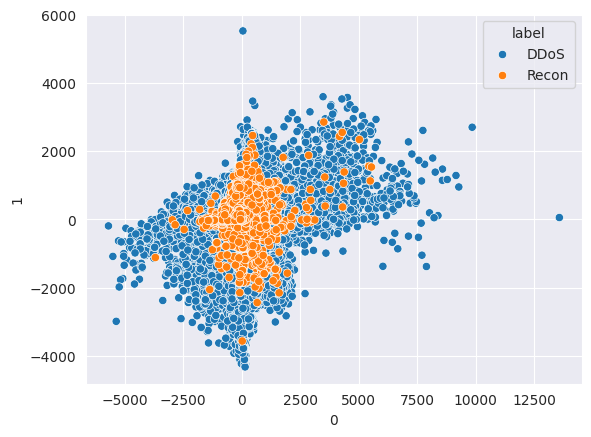

Total visualized data points 461895


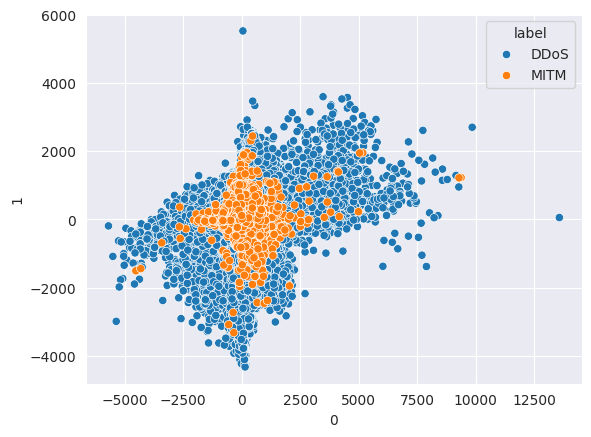

In [41]:
def visualize_DDoS(other_col: str, first_col: str = 'DDoS'):
    if other_col == first_col: return
    new_label = y.mask((y != other_col) & (y != first_col), '0')
    indices_to_visualize = new_label[new_label!='0']
    print('Total visualized data points', len(indices_to_visualize))
    sns.scatterplot(x=reduced_data.loc[indices_to_visualize.index][0], y=reduced_data.loc[indices_to_visualize.index][1], hue = indices_to_visualize)
    plt.show()

for label in labels:
    visualize_DDoS(label)

In [45]:
X['label']=y
X.to_csv('data/processed/train_reduced.csv', index=False)


,flow_time,header_size,packet_duration,overall_rate,src_rate,fin_packets,urg_packets,rst_packets,max_value,value_covariance,...,syn_flags,rst_flags,psh_flags,ack_flags,protocol_http,protocol_https,protocol_tcp,protocol_udp,protocol_icmp,label
0,76.603794,309718.2,66.6,13.144153,13.144153,0.0,79.8,402.2,137.2,1.104977e+03,...,0,0,0,0,0,0,0,0,0,BenignTraffic
1,1.948377,540847.0,80.7,208.633573,208.633573,0.0,15.5,405.5,3830.8,1.370656e+06,...,0,0,0,1,0,1,1,0,0,BenignTraffic
2,54.032302,2794056.4,81.0,48.808104,48.808104,0.0,183.4,2767.5,4193.1,2.244880e+06,...,0,0,0,1,0,1,1,0,0,BenignTraffic
3,3508.455826,1667242.4,2633.8,12.231864,12.231864,0.0,153.1,313.7,251.7,7.725196e+03,...,0,0,0,0,0,0,0,1,0,BenignTraffic
4,3.316233,478693.3,80.8,127.268208,127.268208,0.0,10.8,426.2,2382.8,4.105199e+05,...,0,0,0,1,0,1,1,0,0,BenignTraffic


## Accuracy cycle (Visualizing frequently confusing classess)

Total visualized data points 28417


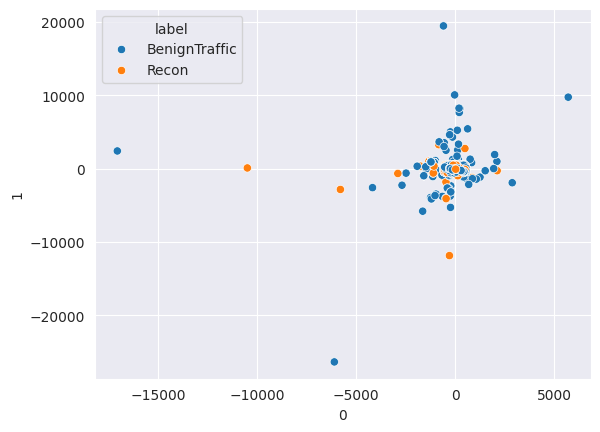

In [22]:
visualize_DDoS("BenignTraffic", "Recon")

Total visualized data points 28298


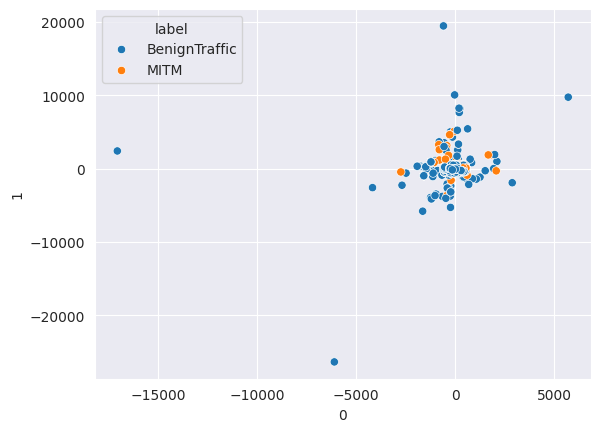

In [23]:
visualize_DDoS("BenignTraffic", "MITM")